In [1]:
import os 
figure_folder = 'figures-v7'
os.makedirs(figure_folder, exist_ok=True)

n_ms_per_s= 1000
n_total_trial= 100

curation = {
    'M15_2': {
        # 'CA1': (3.5, [1, 6, 7, 8, 9, 10, 11, 13, 15,16,20,21, 22, 23, 24, 29, 36, 44, 45, 48]),
        'CA1': (3.5, [1, 6, 7, 8, 9, 10, 11, 13, 15, 24, 29, 36, 44, 45, 48]),
        # Noisy 'M1': [], 
    }, 
    'M15_3': {
       'CA1': (3.5, [25, 29, 34]), 
        'M1': (3.5, [23, 24]), 

    }, 
    'M15_5': {
        'CA1': (3.5, [4, 5, 7, 8, 9, 10, 11, 12, 15, 21, 62, 66]),
        # 'M1': (3.5, [28, 29, 31, 33, 34,35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
        'M1': (3.5, [28, 29, 31, 33, 34,35, 36, 37, 38, 39, 40, 41, 43, 44]),
    }, 
    'M15_7': {
        'CA1': (3.5, [7, 11, 12, 13, 14, 19, 20]),
        # 'M1': (3.5, [4, 6, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30,31,  32,35, 36,  37, 38, 41, 42, 44, 45, 46, 47,48,  51, 52, 53, 55, 56, 57, 58,59,62]),
        'M1': (3.5, [4, 6, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30,31,  32,35, 37, 38, 41, 42, 44, 45, 46, 47,48,  51, 52, 53, 55, 56, 57, 58,59,62]),
    }, 
    'M16_1': {
        # 'CA1': (3.5, [1, 2,3,  4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 22, 25, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 54, 57, 58, 59, 60, 61, 62]),
        'CA1': (3.5, [1, 2,3,  4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 29, 31, 32, 33, 35, 36, 37, 38, 54, 57, 58, 59, 60, 61, 62]),
        # Noisy 'M1': (), 
    },
}    

import os
import shutil 

for subject, subject_curation in curation.items():
    for region, (threshold, curated_units) in subject_curation.items():
        output_folder = f'{figure_folder}/curated/{region}'        
        os.makedirs(output_folder, exist_ok=True)

        for unit_id in curated_units:
            if not os.path.isfile(f'{output_folder}/{subject}-{threshold}-{unit_id}.png'):
                shutil.copy2(f'data/processed/{subject}/{region}/curations-{threshold}/{unit_id}.png', f'{output_folder}/{subject}-{threshold}-{unit_id}.png')

# Reaction Time

In [71]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns

from statannotations.Annotator import Annotator


session_palette = {
    session_index + 1: color for session_index, color in enumerate(['#D1D9EC', '#a2b1d8', '#8597c6', '#697fb7', '#ffbcbb', '#ffb5b4', '#ffaeac', '#ffa6a5', '#e44e4b', '#d93f3c', '#cc3330', '#b03533', '#ddde29', '#bcbd21'])
}

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

reaction_times = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))

    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
        state_ids = np.where(events['state'] == 'state')[0]
        if len(state_ids) > 0:
            events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
            events['x'] = pd.to_numeric(events['x'])
            events['y'] = pd.to_numeric(events['y'])
            events['time'] = pd.to_numeric(events['time'])
            events['state'] = pd.to_numeric(events['state'])
            events['trial'] = pd.to_numeric(events['trial'])
            events['s_trial'] = pd.to_numeric(events['s_trial'])
            events['f_trial'] = pd.to_numeric(events['f_trial'])

        events['x'] = analog_to_digital(events['x'])
        events['y'] = analog_to_digital(events['y'])
        events['position'] = np.sqrt(events['x'] ** 2 + events['y'] ** 2)
        events['time'] = events['time'] - events['time'][0]
        events['time'] = events['time'] / n_ms_per_s 

        for trial in range(n_total_trial):
            trial_indices = np.where(events['trial'] == trial)[0]
            if any(events['state'][trial_indices] == 1):
                trial_reaction_index = np.where((events['trial'] == trial) & (events['state'] == 1))[0][0]
                reaction_times.append({
                    'subject': subject,
                    'session': session_index+1,
                    'reaction': events['time'][trial_reaction_index] - events['time'][trial_indices.min()],
                })
        
reaction_times = pd.DataFrame(reaction_times)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

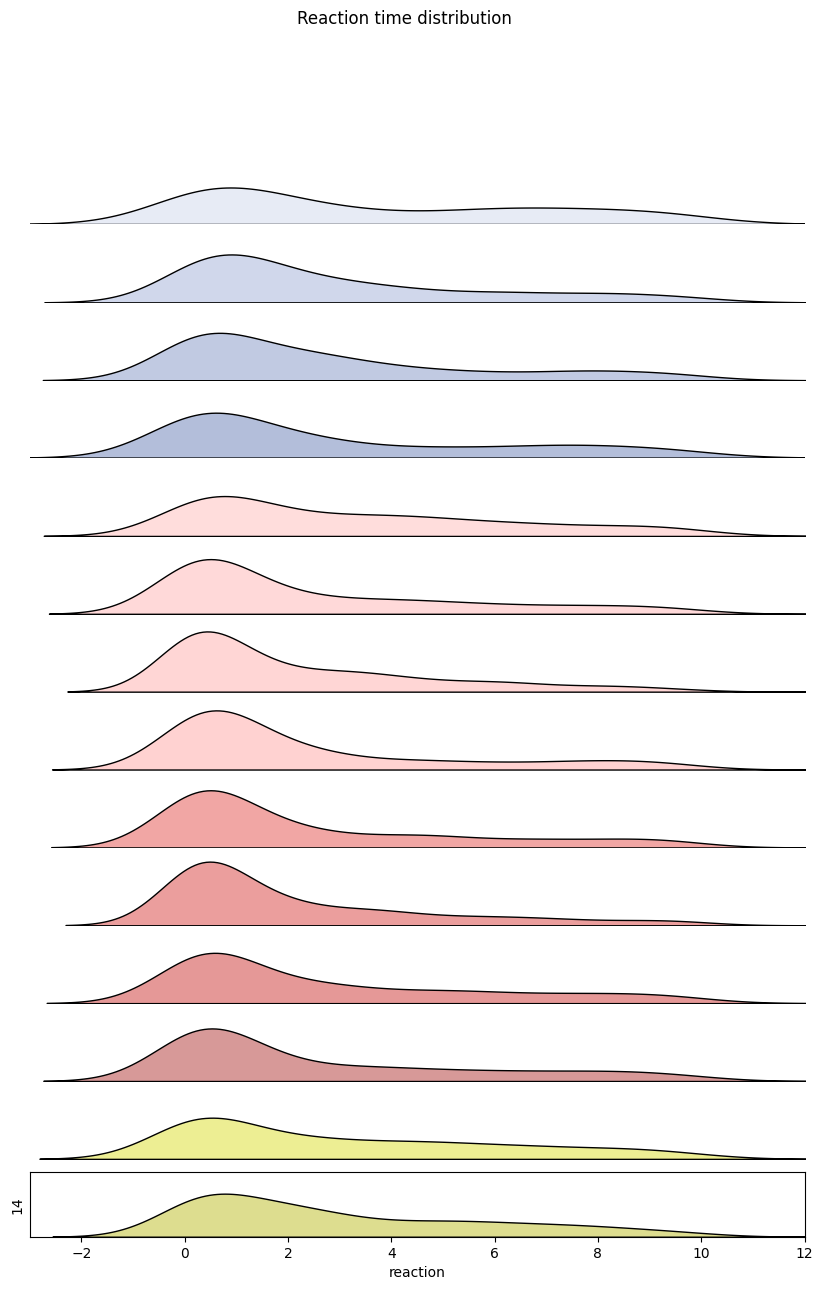

In [ ]:
fig = plt.figure(figsize=(10, 15))
for session in range(1, reaction_times['session'].max()+1):
    ax = plt.subplot(len(reaction_times['session'].unique())+1, 1, session)
    sns.kdeplot(data=reaction_times[reaction_times['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
    ax.set_ylim(0, 0.28)
    ax.set_xlim(-3, 12)
    ax.set_ylabel(session)
    ax.set_yticks([])
    ax.set_axis_off()
ax.set_axis_on()
fig.suptitle(f'Reaction time distribution')
plt.savefig(f'{figure_folder}/reaction_density.pdf')
plt.show()
plt.close()

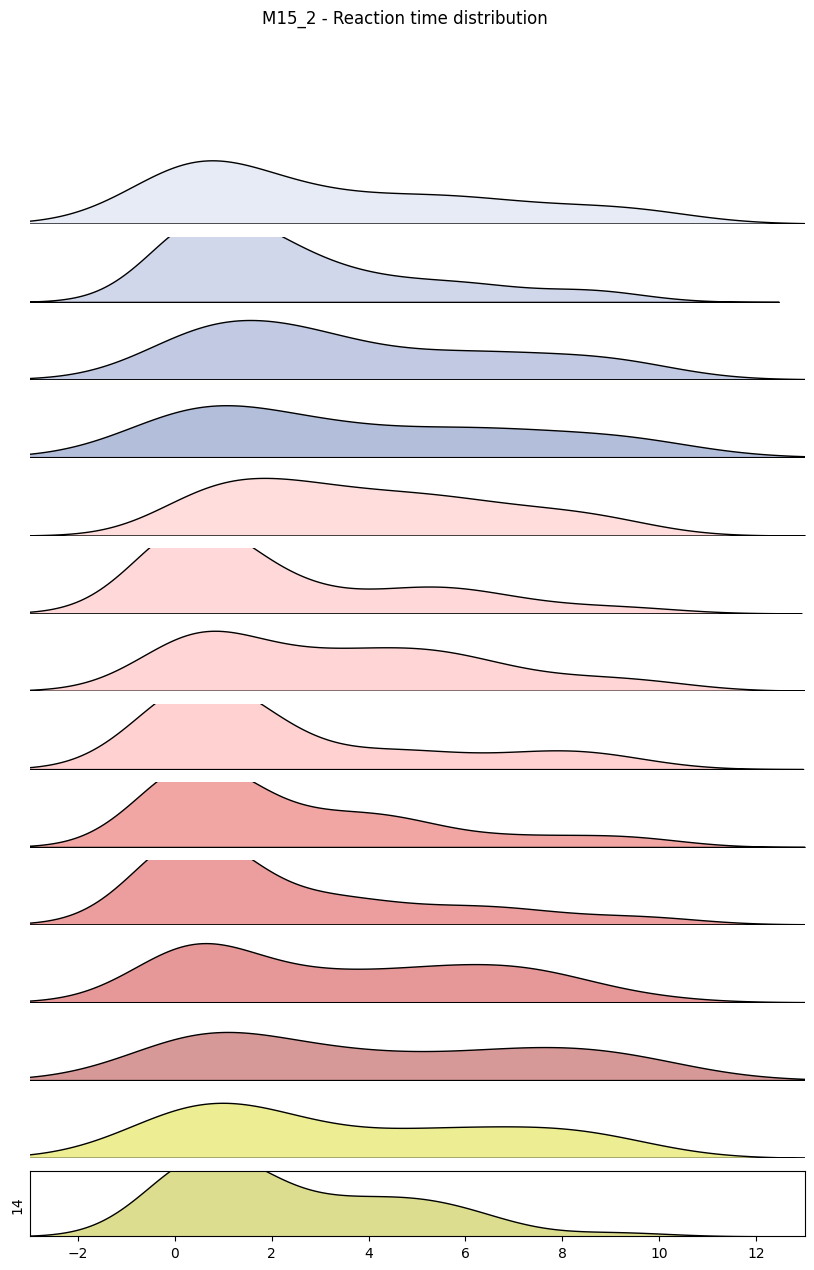

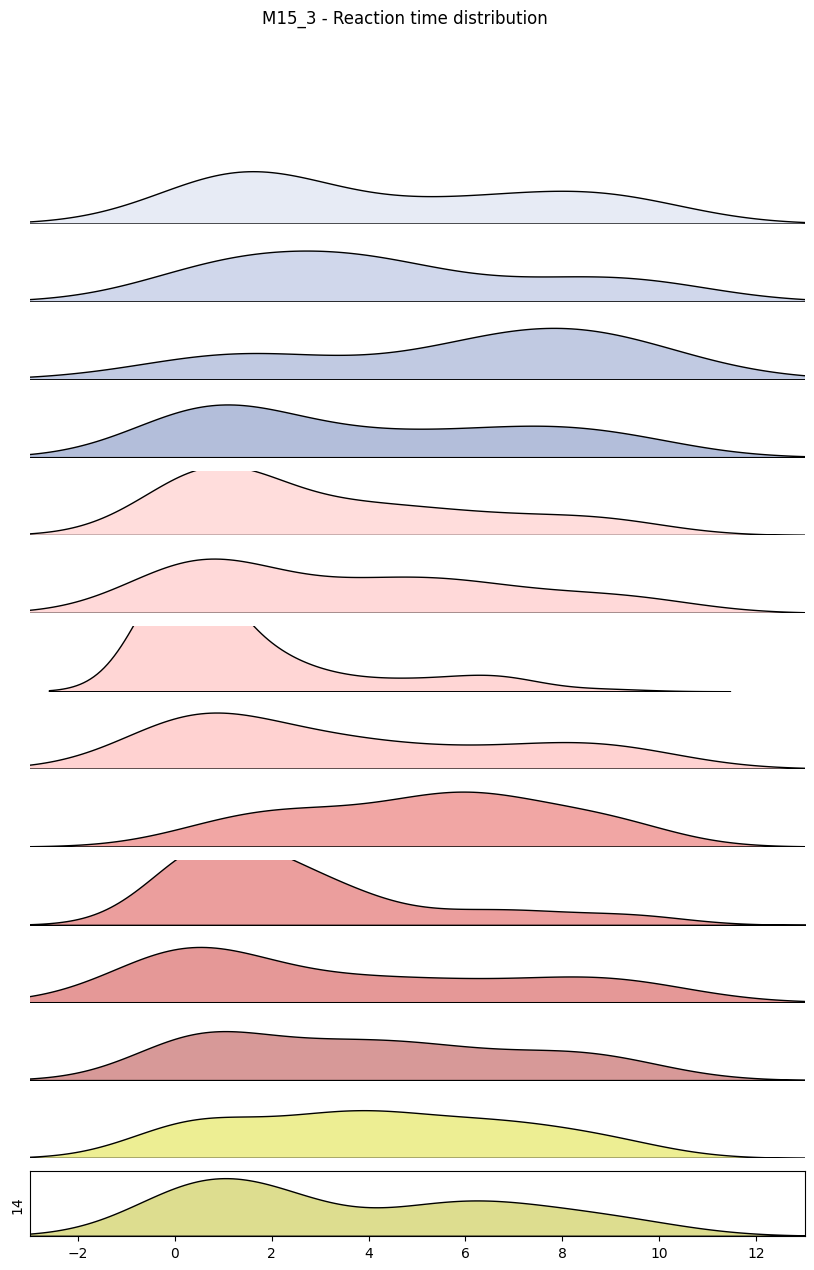

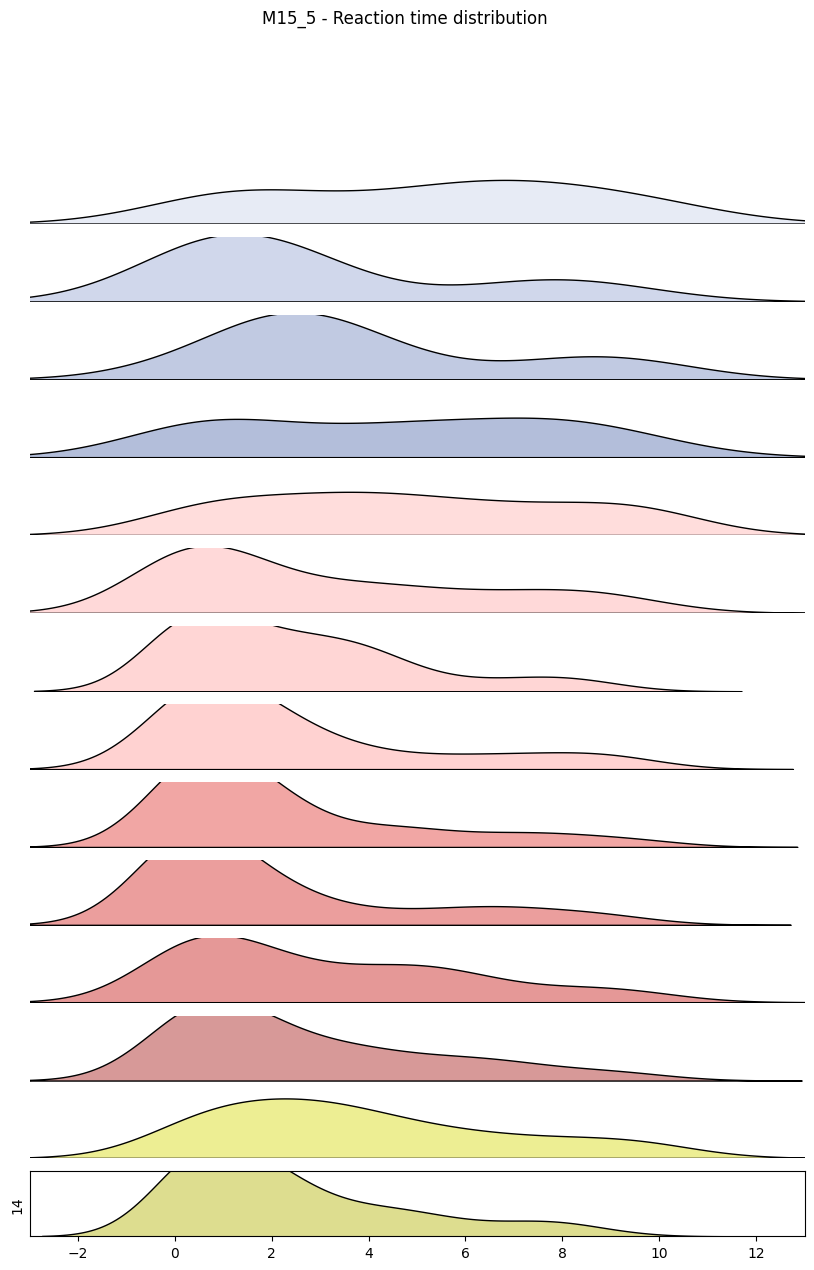

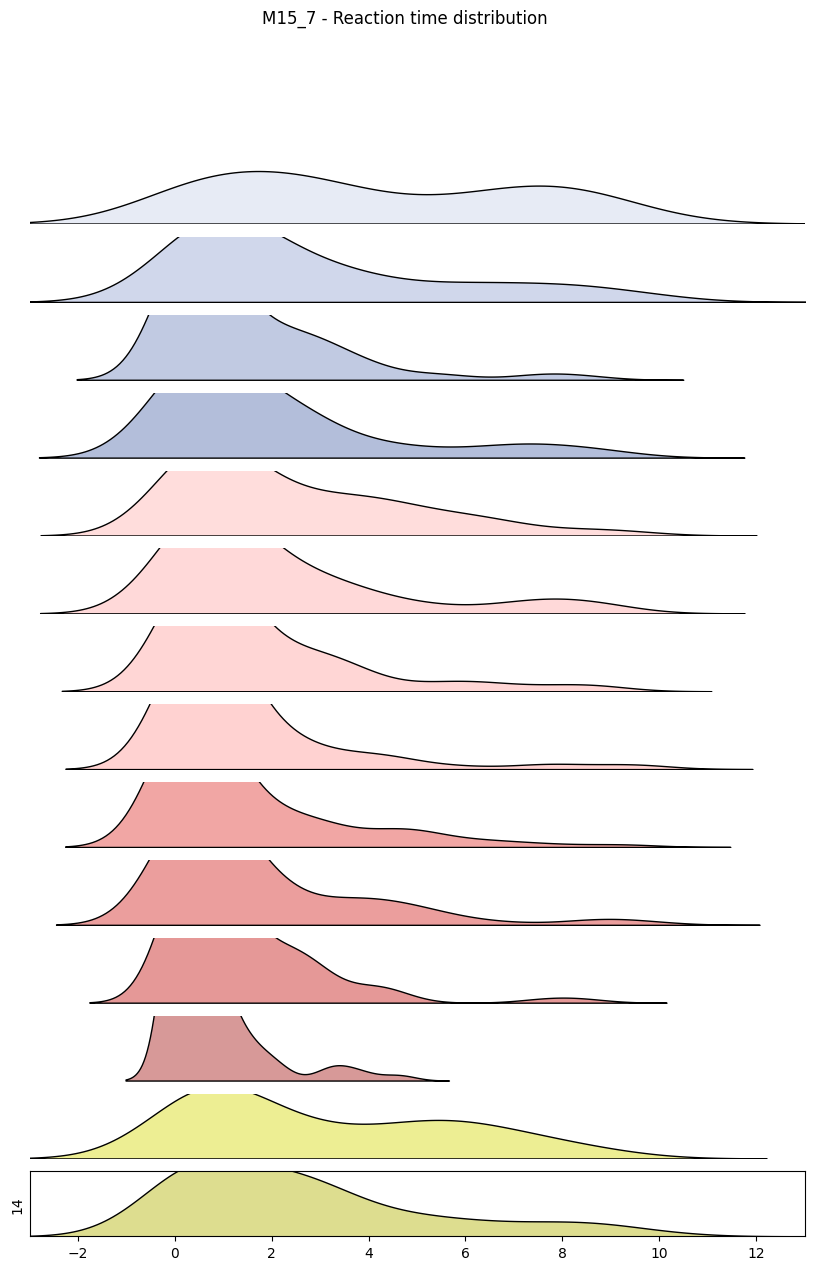

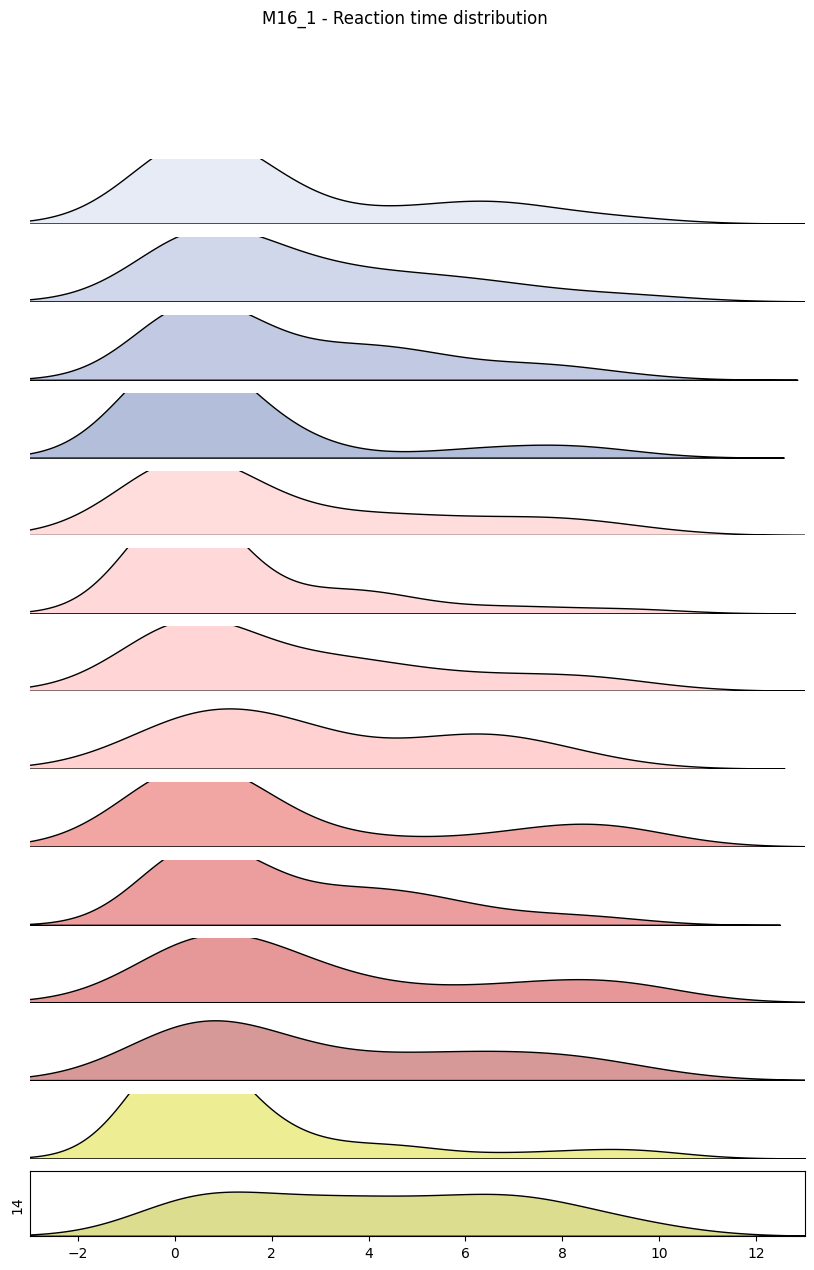

In [ ]:
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    stats = reaction_times[reaction_times['subject']==subject]
    fig = plt.figure(figsize=(10, 15))
    for session in range(1, stats['session'].max()+1):
        ax = plt.subplot(len(stats['session'].unique())+1, 1, session)
        sns.kdeplot(data=stats[stats['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
        ax.set_ylim(0, 0.15)
        ax.set_xlim(-3, 13)
        ax.set_ylabel(session)
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_axis_off()
    ax.set_axis_on()
    fig.suptitle(f'{subject} - Reaction time distribution')
    plt.savefig(f'{figure_folder}/{subject}_reaction_density.pdf')
    plt.show()
    plt.close()

# Success Rate

In [ ]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

half_successes = []
successes = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))
    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        half_successes.append({
            'rate': events['s_trial'].tolist()[np.where(events['trial'] == (n_total_trial//2))[0][-1]]/(n_total_trial//2),
            'subject': subject,
            'session': session_index+1,
        })
        successes.append({
            'rate': events['s_trial'].tolist()[-1]/n_total_trial,
            'subject': subject,
            'session': session_index+1,
        })
half_successes = pd.json_normalize(half_successes)
successes = pd.json_normalize(successes)

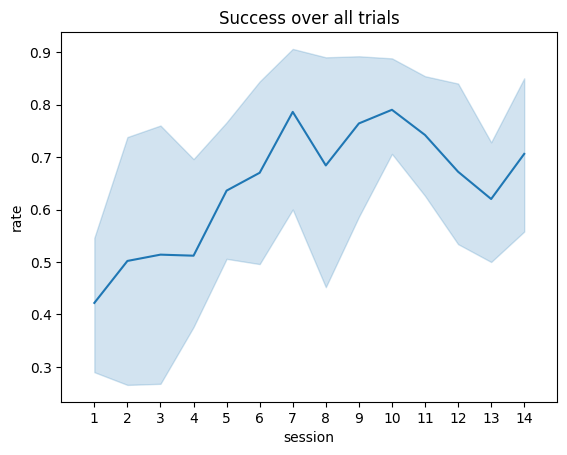

In [ ]:
plt.figure()
sns.lineplot(data=successes, x='session', y='rate')#, hue='subject')
plt.title('Success over all trials')
plt.xlim(0, 15)
plt.xticks(np.arange(1, 15))
plt.savefig(f'{figure_folder}/rate_line.pdf')
plt.show()
plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 6: Welch's t-test independent samples, P_val:8.960e-02 t=-1.968e+00
1 vs. 10: Welch's t-test independent samples, P_val:3.782e-03 t=-4.134e+00
1 vs. 14: Welch's t-test independent samples, P_val:3.899e-02 t=-2.491e+00


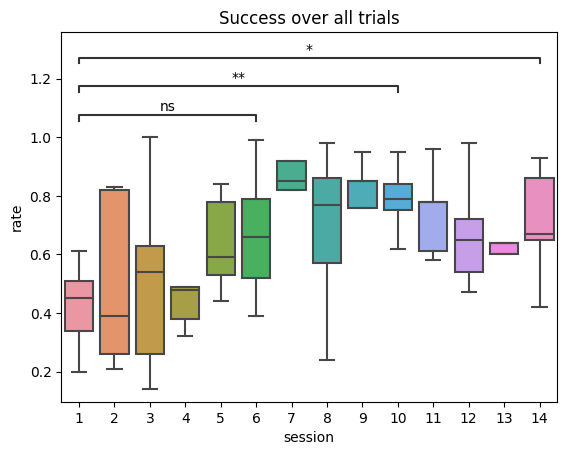

In [ ]:
plt.figure()
ax = plt.gca()
sns.boxplot(data=successes, x='session', y='rate', showfliers=False, ax=ax)#, hue='subject')
plt.title('Success over all trials')
pairs = [(1, 6), (1, 10), (1, 14)]
annotator = Annotator(ax, pairs, data=successes, x='session', y='rate')
annotator.configure(test="t-test_welch").apply_and_annotate()
plt.savefig(f'{figure_folder}/rate_box.pdf')
plt.show()
plt.close()

# Unit by Session (Raster and PSTH)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
plotted_units = {
    'main': {
        # ('CA1', 'M15_2', 11): ('#667872', np.arange(n_segment)),
        ('CA1', 'M16_1', 59): ('#667872', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [1, 4, 10]),
        # ('CA1', 'M16_1', 3): ('#667872', [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13]),
        ('CA1', 'M16_1', 33): ('#9f4854', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13], [1, 4, 10]),
        ('CA1', 'M16_1', 54): ('#da8430', [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13], [2, 4, 10]),
        # ('CA1', 'M15_3', 29): ('#a2b1d8', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]),
        ('M1', 'M15_3', 23): ('#a2b1d8', [0, 1, 3, 7, 8, 9, 10, 11, 12, 13], [0, 7, 13]),},
    'SI': {
        ('CA1', 'M16_1', 2): ('#9f4854', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13], [1, 7, 13]),
        ('CA1', 'M16_1', 8): ('#9f4854', [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13], [1, 8, 13]),

        ('CA1', 'M15_2', 36): ('#667872', np.arange(n_segment), [0, 7, 13]),
        ('M1', 'M15_7', 29): ('#667872', np.arange(n_segment), [0, 7, 13]),
        ('M1', 'M15_7', 46): ('#667872', np.arange(n_segment), [0, 7, 13]),
    },

    # ('CA1', 'M16_1', 26): ('#a2b1d8', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]),
    # ('CA1', 'M16_1', 58): ('#a2b1d8', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]),

    # ('CA1', 'M15_5', 8): ('#667872', np.arange(n_segment)),
    # ('CA1', 'M15_5', 33): ('#9f4854', np.arange(n_segment)),
    # ('CA1', 'M16_1', 10): ('#9f4854', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]),
    # ('M1', 'M15_7', 32): ('#667872', np.arange(n_segment)),
    # ('M1', 'M15_7', 52): ('#9f4854', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    # ('M1', 'M15_7', 55): ('#9f4854', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]),
    # ('M1', 'M15_7', 56): ('#9f4854', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    # ('M1', 'M15_7', 59): ('#9f4854', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
}

n_ms_per_s = 1000
s_before, s_after = 1, 1
bin_size_ms = 200

for figure_group, group_plotted_units in plotted_units.items():
    for (region, subject, unit_id), (color, plotted_segments, psth_segments) in group_plotted_units.items():
        output_folder = f'{figure_folder}/raster-PSTH-{figure_group}/({bin_size_ms}ms)-success/{region}'
        os.makedirs(output_folder, exist_ok=True)
        unit_plot_file = f'{output_folder}/{subject}-{threshold}-{unit_id}.png'
        if os.path.isfile(unit_plot_file):
            continue

        session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
            
        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

        cue_spike_trains, cue_spike_bins, cue_train_counts = [], [], []
        
        for segment_index in plotted_segments:
            segment_info = session_info[session_info['segment_index'] == segment_index]

            controller_date = segment_info['segment_path'].item().split('_')[-2]
            controller_date = controller_date[2:] + controller_date[:2]
            controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
            events = pd.read_csv(controller_file)
            # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
            state_ids = np.where(events['state'] == 'state')[0]
            if len(state_ids) > 0:
                events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                
            s_trials, f_trials = [], []
            reaction_times = {} # in ms
            for trial in range(n_total_trial):
                trial_indices = np.where(events['trial'] == trial)[0]
                if any(events['state'][trial_indices] == 1):
                    s_trials.append(trial)
                    # The first index having "triggered state" (1) and event trial number marks the reacted time.
                    reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                    # Off set the reaction time to the start of the trial.
                    reaction_time -= events['time'].tolist()[trial_indices.min()]
                    reaction_times[trial] = reaction_time / n_ms_per_s
                else:
                    f_trials.append(trial)
            assert len(s_trials) + len(f_trials) == n_total_trial
            
            trial_starts = eval(segment_info['trial_starts'].item())
            trial_ends = eval(segment_info['trial_ends'].item())

            unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

            segment_cue_spike_trains, segment_cue_spike_bins = [], []
            for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                if trial not in s_trials: continue

                t_cue_start = trial_start - s_before * sorting.sampling_frequency
                t_cue_end = trial_start + s_after * sorting.sampling_frequency

                cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                cue_spike_train = cue_spike_train / sorting.sampling_frequency
                segment_cue_spike_trains.append(cue_spike_train)

                cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
                segment_cue_spike_bins.append(cue_spike_bin)
            segment_cue_spike_bins = np.array(segment_cue_spike_bins)
            segment_cue_spike_bins = segment_cue_spike_bins.mean(0)
            segment_cue_spike_bins -= segment_cue_spike_bins.min()
            
            cue_spike_trains.extend(segment_cue_spike_trains)
            cue_spike_bins.append(segment_cue_spike_bins)
            cue_train_counts.append(len(cue_spike_trains))

        cue_spike_bins = np.array(cue_spike_bins)
        cue_spike_bins = cue_spike_bins / cue_spike_bins.max()

        data = []
        for segment_index in range(cue_spike_bins.shape[0]):
            for time_index in range(cue_spike_bins.shape[1]):
                data.append({
                    'segment': segment_index+1,
                    'time': time_index,
                    'offsetted firing counts': cue_spike_bins[segment_index, time_index],
                })
        data = pd.json_normalize(data)

        ncol = 3
        fig = plt.figure(figsize=(7, 24))
        fig.suptitle(f'{subject} - {region} - {unit_id}')
        ax = plt.subplot(2, 2, 1)
        ax.eventplot(cue_spike_trains, colors=color)
        for segment_index, y in zip(plotted_segments, cue_train_counts):
            ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
            ax.text(s_after+0.2, y, f'{segment_index+1}')
        ax.set_ylabel('trials')
        ax.set_title('relative to cue')
        ax.set_xticks([-1, 0, 1])

        for plot_index, (segment_index, segment_spike_bins) in enumerate(zip(plotted_segments, cue_spike_bins)):
            ax = plt.subplot(n_segment, ncol, ncol*(n_segment-(plot_index+1))+ncol)
            ax.plot(segment_spike_bins, color=color)
            ax.set_ylabel(segment_index+1)
            ax.set_xticks([0, 5, 10], [-1, 0, 1])
            ax.set_xlim(-2, 12)
            ax.set_ylim(0, cue_spike_bins.max())
            ax.set_yticks([0, 0.5])

        ax = plt.subplot(4, 2, 7)
        sns.lineplot(data=data, x='time', y='offsetted firing counts', ax=ax, color=color)

        plt.tight_layout()
        plt.savefig(unit_plot_file)#, transparent=True)
        # plt.show()
        plt.close()


        fig = plt.figure(figsize=(3, 10))
        fig.suptitle(f'{subject} - {region} - {unit_id}')
        ax = plt.gca()
        ax.eventplot(cue_spike_trains, colors=color)
        for segment_index, y in zip(plotted_segments, cue_train_counts):
            ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
            ax.text(s_after+0.2, y, f'{segment_index+1}')
        ax.set_ylabel('trials')
        ax.set_title('relative to cue')
        ax.set_xticks([-1, 0, 1])
        ax.set_axis_off()
        plt.savefig(f'{output_folder}/{subject}-{threshold}-{unit_id}-raster.png', transparent=True)
        # plt.show()
        plt.close()

        fig = plt.figure(figsize=(2, 20))
        for plot_index, (segment_index, segment_spike_bins) in enumerate(zip(plotted_segments, cue_spike_bins)):
            ax = plt.subplot(len(plotted_segments), 1, plot_index+1)
            ax.plot(segment_spike_bins, color=color)
            ax.set_ylabel(segment_index+1)
            ax.set_xticks([0, 4.5, 9], [-1, 0, 1])
            ax.set_xlim(-2, 12)
            ax.set_ylim(0, cue_spike_bins.max())
            ax.set_yticks([0, 0.5])
        plt.tight_layout()
        plt.savefig(f'{output_folder}/{subject}-{threshold}-{unit_id}-PSTH.pdf')
        # plt.show()
        plt.close()

        fig = plt.figure(figsize=(3, 3))
        ax = plt.gca()
        for plot_index, (segment_index, segment_spike_bins) in enumerate(zip(plotted_segments, cue_spike_bins)):
            if segment_index in psth_segments:
                ax.plot(segment_spike_bins, color=color, alpha=min(1, 0.42+0.58*plot_index/10))
        ax.plot(cue_spike_bins.mean(0), color='gray', linestyle='--')
        ax.set_xticks([0, 4.5, 9], [-1, 0, 1])
        ax.set_ylim(0, 1)
        plt.tight_layout()
        plt.savefig(f'{output_folder}/{subject}-{threshold}-{unit_id}-PSTH-summary.pdf')
        # plt.show()
        plt.close()

# Experimental

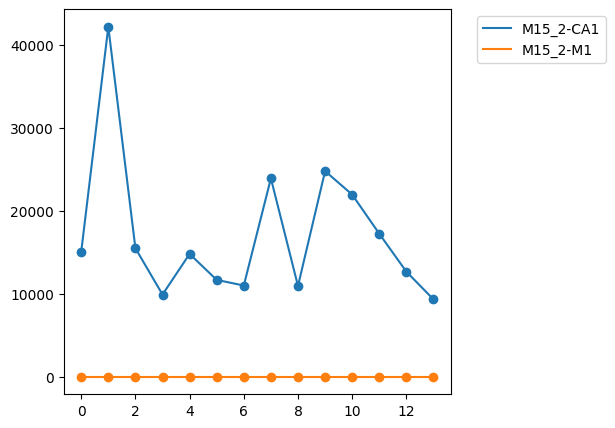

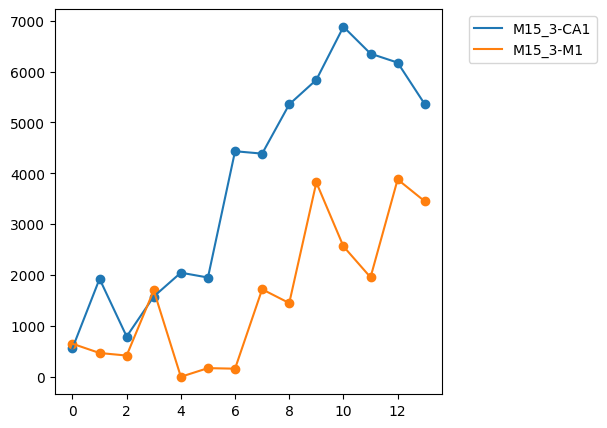

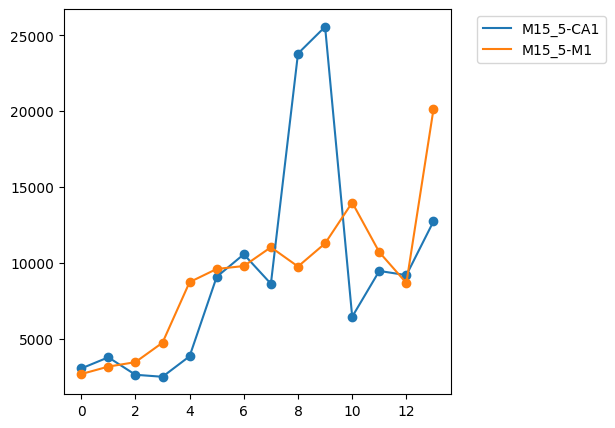

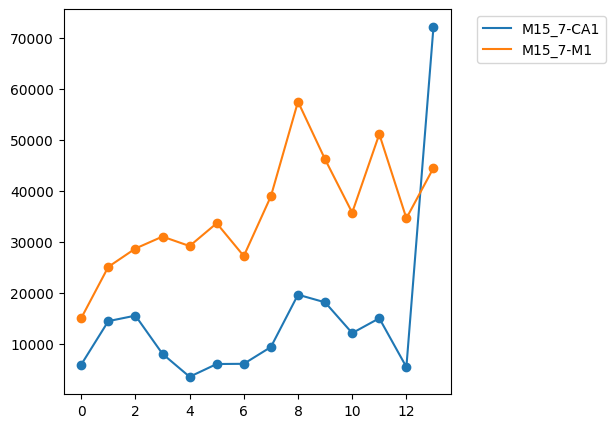

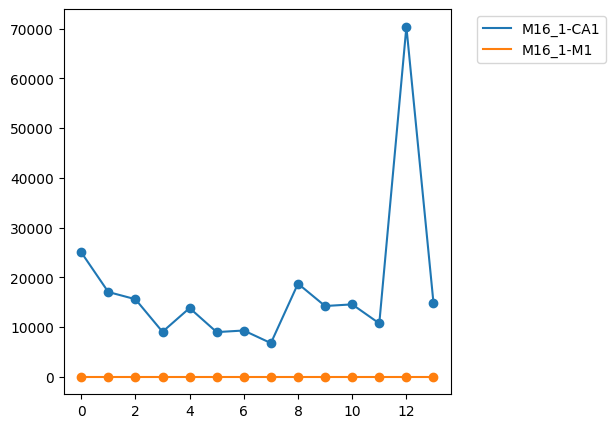

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1

table = []

for subject, subject_curation in curation.items():
    # #############################################################
    # if subject != 'M15_3': continue 
    # #############################################################

    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    subject_spike_trains = {}
    if not os.path.isfile(f'{figure_folder}/{subject}_spike_trains_all.pickle'):
        for region, (threshold, curated_units) in subject_curation.items():
            # output_folder = f'{figure_folder}/experimental/{region}'
            # os.makedirs(output_folder, exist_ok=True)
            
            recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
            recording = sc.concatenate_recordings(recordings)

            sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
            sorting = scu.remove_excess_spikes(sorting, recording)
            sortings = sc.split_sorting(sorting, recordings)
            sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

            n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

            for unit_id in tqdm(curated_units):        
                cue_spike_trains = []
                
                for segment_index in range(n_segment):
                    segment_info = session_info[session_info['segment_index'] == segment_index]

                    controller_date = segment_info['segment_path'].item().split('_')[-2]
                    controller_date = controller_date[2:] + controller_date[:2]
                    controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                    events = pd.read_csv(controller_file)
                    # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                    state_ids = np.where(events['state'] == 'state')[0]
                    if len(state_ids) > 0:
                        events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                        
                    s_trials, f_trials = [], []
                    reaction_times = {} # in ms
                    for trial in range(n_total_trial):
                        trial_indices = np.where(events['trial'] == trial)[0]
                        if any(events['state'][trial_indices] == 1):
                            s_trials.append(trial)
                            # The first index having "triggered state" (1) and event trial number marks the reacted time.
                            reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                            # Off set the reaction time to the start of the trial.
                            reaction_time -= events['time'].tolist()[trial_indices.min()]
                            reaction_times[trial] = reaction_time / n_ms_per_s
                        else:
                            f_trials.append(trial)
                    assert len(s_trials) + len(f_trials) == n_total_trial
                    
                    trial_starts = eval(segment_info['trial_starts'].item())
                    trial_ends = eval(segment_info['trial_ends'].item())

                    unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                    segment_cue_spike_trains = []
                    for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                        # if trial not in s_trials: continue

                        t_cue_start = trial_start - s_before * sorting.sampling_frequency
                        t_cue_end = trial_start + s_after * sorting.sampling_frequency

                        cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                        cue_spike_train = cue_spike_train / sorting.sampling_frequency
                        segment_cue_spike_trains.append(cue_spike_train)

                    cue_spike_trains.append(segment_cue_spike_trains)
                
                subject_spike_trains[(region, unit_id)] = cue_spike_trains
        with open(f'{figure_folder}/{subject}_spike_trains_all.pickle', 'wb') as file:
            # Serialize and save the object to the file
            pickle.dump(subject_spike_trains, file)

    subject_spike_trains = pickle.load(open(f'{figure_folder}/{subject}_spike_trains.pickle', 'rb'))

    counts = { 'CA1': [0 for _ in range(n_segment)], 'M1': [0 for _ in range(n_segment)] }
    for (region, unit_id), cue_spike_trains in subject_spike_trains.items():
        for segment_index, segment_cue_spike_trains in enumerate(cue_spike_trains):
            counts[region][segment_index] += (np.sum([cue_spike_train.size for cue_spike_train in segment_cue_spike_trains]))
    
    fig = plt.figure(figsize=(5, 5))
    for region, region_counts in counts.items():
        plt.plot(region_counts, label=f'{subject}-{region}')
        plt.scatter(np.arange(n_segment), region_counts)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    for region, region_counts in counts.items():
        for segment_index, segment_count in enumerate(region_counts):
            table.append({
                'subject': subject,
                'region': region,
                'segment': segment_index+1,
                'count': segment_count,
            })
    pd.json_normalize(table).to_csv('counts_all.csv', index=False)

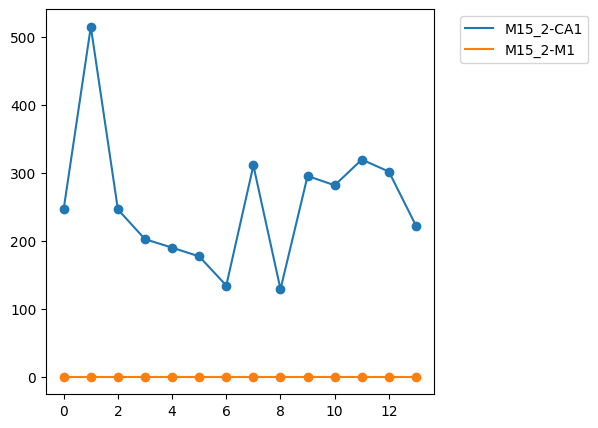

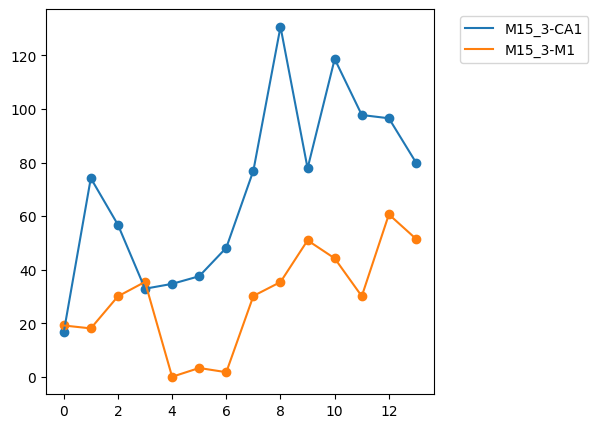

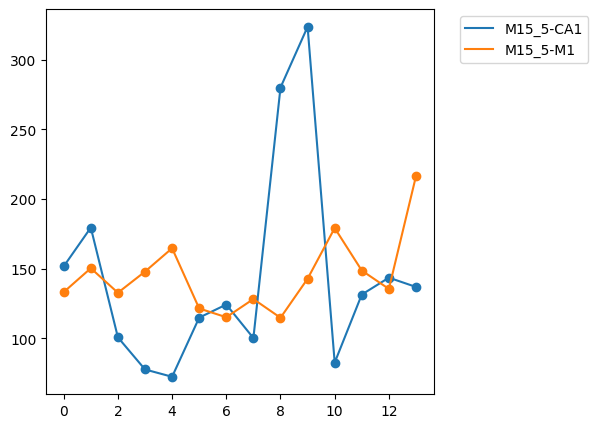

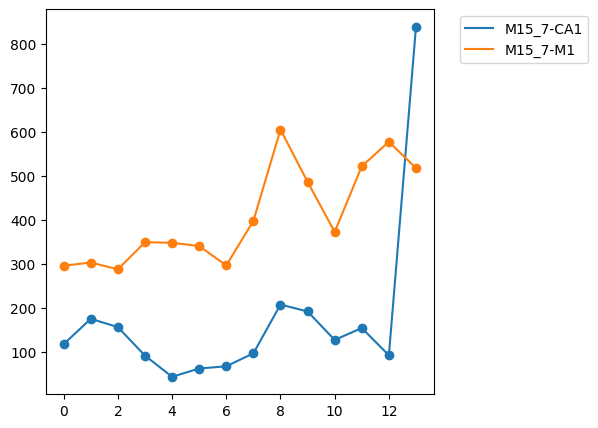

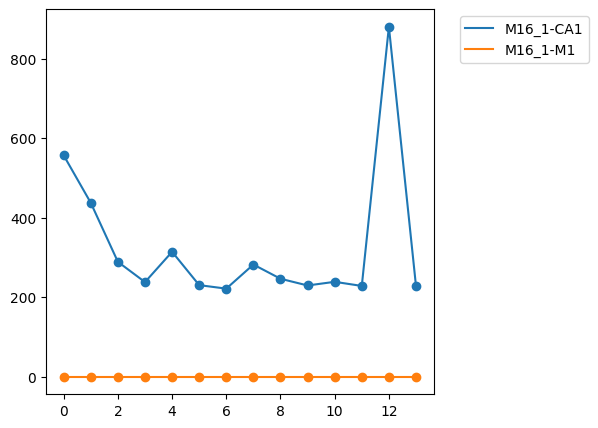

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1

table = []

for subject, subject_curation in curation.items():
    # #############################################################
    # if subject != 'M15_3': continue 
    # #############################################################

    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    subject_spike_trains = {}
    if not os.path.isfile(f'{figure_folder}/{subject}_spike_trains.pickle'):
        for region, (threshold, curated_units) in subject_curation.items():
            # output_folder = f'{figure_folder}/experimental/{region}'
            # os.makedirs(output_folder, exist_ok=True)
            
            recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
            recording = sc.concatenate_recordings(recordings)

            sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
            sorting = scu.remove_excess_spikes(sorting, recording)
            sortings = sc.split_sorting(sorting, recordings)
            sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

            n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

            for unit_id in tqdm(curated_units):        
                cue_spike_trains = []
                
                for segment_index in range(n_segment):
                    segment_info = session_info[session_info['segment_index'] == segment_index]

                    controller_date = segment_info['segment_path'].item().split('_')[-2]
                    controller_date = controller_date[2:] + controller_date[:2]
                    controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                    events = pd.read_csv(controller_file)
                    # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                    state_ids = np.where(events['state'] == 'state')[0]
                    if len(state_ids) > 0:
                        events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                        
                    s_trials, f_trials = [], []
                    reaction_times = {} # in ms
                    for trial in range(n_total_trial):
                        trial_indices = np.where(events['trial'] == trial)[0]
                        if any(events['state'][trial_indices] == 1):
                            s_trials.append(trial)
                            # The first index having "triggered state" (1) and event trial number marks the reacted time.
                            reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                            # Off set the reaction time to the start of the trial.
                            reaction_time -= events['time'].tolist()[trial_indices.min()]
                            reaction_times[trial] = reaction_time / n_ms_per_s
                        else:
                            f_trials.append(trial)
                    assert len(s_trials) + len(f_trials) == n_total_trial
                    
                    trial_starts = eval(segment_info['trial_starts'].item())
                    trial_ends = eval(segment_info['trial_ends'].item())

                    unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                    segment_cue_spike_trains = []
                    for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                        if trial not in s_trials: continue

                        t_cue_start = trial_start - s_before * sorting.sampling_frequency
                        t_cue_end = trial_start + s_after * sorting.sampling_frequency

                        cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                        cue_spike_train = cue_spike_train / sorting.sampling_frequency
                        segment_cue_spike_trains.append(cue_spike_train)

                    cue_spike_trains.append(segment_cue_spike_trains)
                
                subject_spike_trains[(region, unit_id)] = cue_spike_trains
        with open(f'{figure_folder}/{subject}_spike_trains.pickle', 'wb') as file:
            # Serialize and save the object to the file
            pickle.dump(subject_spike_trains, file)

    subject_spike_trains = pickle.load(open(f'{figure_folder}/{subject}_spike_trains.pickle', 'rb'))

    counts = { 'CA1': [0 for _ in range(n_segment)], 'M1': [0 for _ in range(n_segment)] }
    for (region, unit_id), cue_spike_trains in subject_spike_trains.items():
        for segment_index, segment_cue_spike_trains in enumerate(cue_spike_trains):
            counts[region][segment_index] += (np.mean([cue_spike_train.size for cue_spike_train in segment_cue_spike_trains]))
    
    fig = plt.figure(figsize=(5, 5))
    for region, region_counts in counts.items():
        plt.plot(region_counts, label=f'{subject}-{region}')
        plt.scatter(np.arange(n_segment), region_counts)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    for region, region_counts in counts.items():
        for segment_index, segment_count in enumerate(region_counts):
            table.append({
                'subject': subject,
                'region': region,
                'segment': segment_index+1,
                'count': segment_count,
            })

In [4]:
pd.json_normalize(table).to_csv('counts.csv', index=False)

In [11]:
segment_cue_spike_trains[0].size

9

In [57]:
import copy
subject_spike_trains_OG = copy.deepcopy(subject_spike_trains)



In [59]:
subject_spike_trains.keys()

dict_keys([('CA1', 1), ('CA1', 2), ('CA1', 3), ('CA1', 4), ('CA1', 5), ('CA1', 6), ('CA1', 7), ('CA1', 8), ('CA1', 9), ('CA1', 10), ('CA1', 11), ('CA1', 12), ('CA1', 13), ('CA1', 14), ('CA1', 25), ('CA1', 26), ('CA1', 27), ('CA1', 29), ('CA1', 31), ('CA1', 32), ('CA1', 33), ('CA1', 35), ('CA1', 36), ('CA1', 37), ('CA1', 38), ('CA1', 54), ('CA1', 57), ('CA1', 58), ('CA1', 59), ('CA1', 60), ('CA1', 61), ('CA1', 62)])

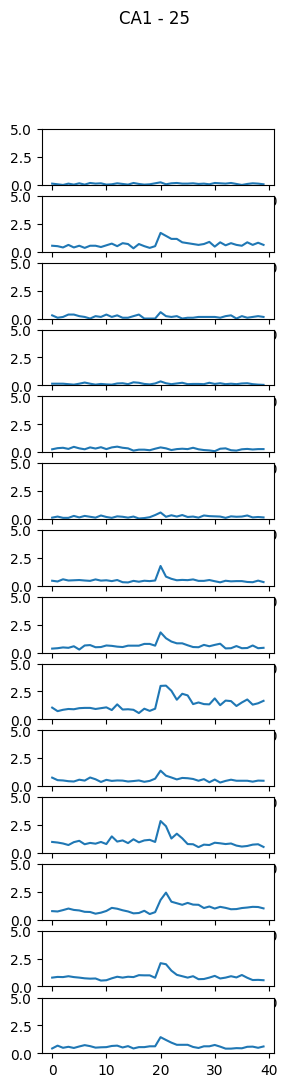

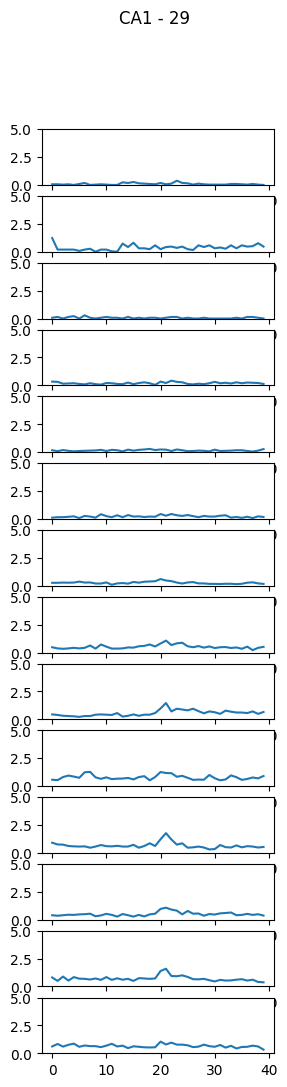

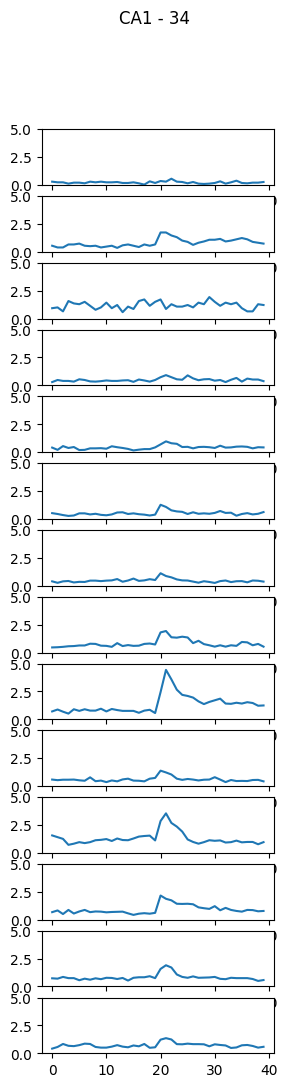

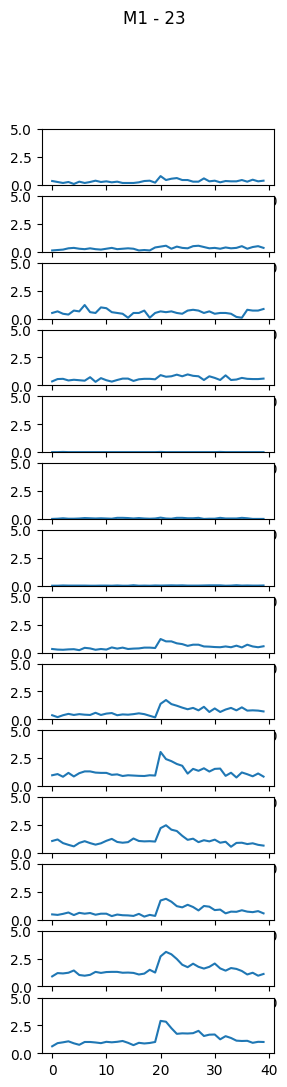

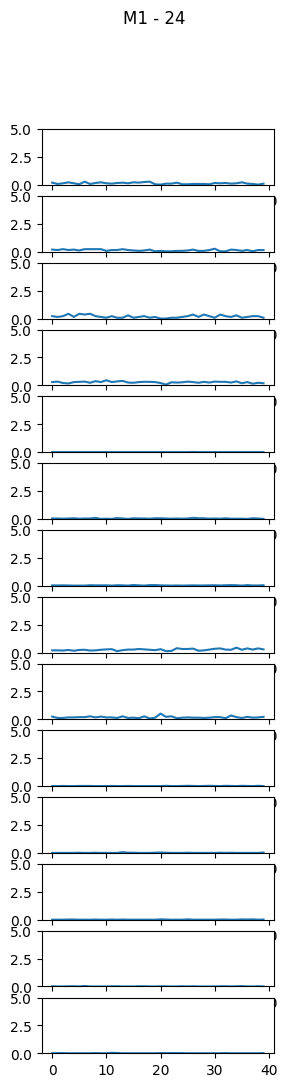

In [36]:
bin_size_ms = 50
subject_spike_bins = {}
for key, cue_spike_trains in subject_spike_trains.items():
    cue_spike_bins = []
    for segment_cue_spike_trains in cue_spike_trains:
        segment_cue_spike_bins = []
        for cue_spike_train in segment_cue_spike_trains:
            cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
            segment_cue_spike_bins.append(cue_spike_bin)
        cue_spike_bins.append(np.array(segment_cue_spike_bins))
    subject_spike_bins[key] = cue_spike_bins

mean_subject_spike_bins = {}
for key, cue_spike_bins in subject_spike_bins.items():
    mean_cue_spike_bins = []
    for segment_cue_spike_bins in cue_spike_bins:
        mean_cue_spike_bins.append(segment_cue_spike_bins.mean(0))
    mean_subject_spike_bins[key] = np.array(mean_cue_spike_bins)

for (region, unit_id), mean_cue_spike_bins in mean_subject_spike_bins.items():
    fig = plt.figure(figsize=(3, 12))
    for segment_index, segment_mean_cue_spike_bins in enumerate(mean_cue_spike_bins):
        ax = plt.subplot(n_segment, 1, segment_index+1)
        ax.plot(segment_mean_cue_spike_bins)
        ax.set_ylim(0, 5)
    fig.suptitle(f'{region} - {unit_id}')
    plt.show()
    plt.close()

In [18]:
subject_spike_bins[('CA1', 25)][0].shape

(34, 20)

In [23]:
segment_cue_spike_bins.shape

(67, 20)

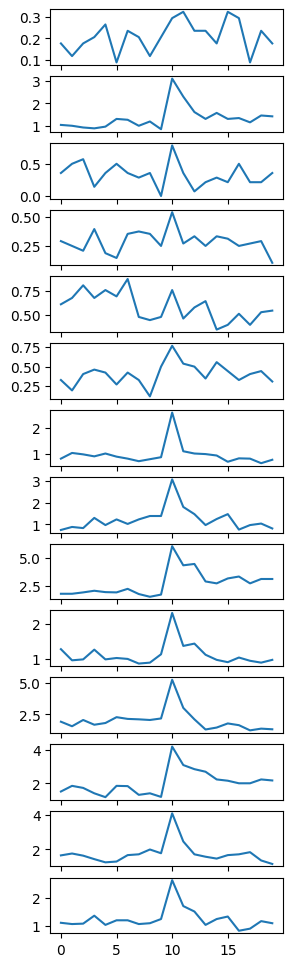

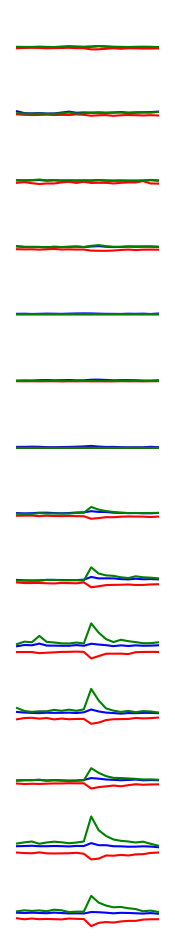

In [54]:
bin_size_ms = 100
subject_spike_bins = {}
for key, cue_spike_trains in subject_spike_trains.items():
    cue_spike_bins = []
    for segment_cue_spike_trains in cue_spike_trains:
        segment_cue_spike_bins = []
        for cue_spike_train in segment_cue_spike_trains:
            cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
            segment_cue_spike_bins.append(cue_spike_bin)
        cue_spike_bins.append(np.array(segment_cue_spike_bins))
    subject_spike_bins[key] = cue_spike_bins

mean_subject_spike_bins = {}
for key, cue_spike_bins in subject_spike_bins.items():
    mean_cue_spike_bins = []
    for segment_cue_spike_bins in cue_spike_bins:
        mean_cue_spike_bins.append(segment_cue_spike_bins.mean(0))
    mean_subject_spike_bins[key] = np.array(mean_cue_spike_bins)

pair1 = ('CA1', 29)
pair2 = ('M1', 23)
fig = plt.figure(figsize=(2, 12))
for segment_index, (bin1, bin2) in enumerate(zip(mean_subject_spike_bins[pair1], mean_subject_spike_bins[pair2])):
    ax = plt.subplot(n_segment, 1, segment_index+1)
    ax.plot(bin1, color='blue')
    ax.plot(bin2*-1, color='red')
    ax.plot(bin1 * bin2, color='green')
    ax.set_ylim(-10, 20)
    ax.set_axis_off()
plt.show()
plt.close()